# Multi-voxel pattern analysis

This week we will use a popular python library to do simple classification of a fake data set, and of some real fMRI data. My original intent was to implement a linear discriminant from scratch, but... that's a bit more math than we have time for in this session. So instead, we will explore [`sklearn`](http://scikit-learn.org/stable/) a bit, and show you how to make use of python libraries to solve your problems.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import nibabel
import h5py
import os

# For to fancy
#import fakedata as fd
import cortex as cx

# For to machine learn
from sklearn import svm
from sklearn import discriminant_analysis as da

%matplotlib inline

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Simple classifier with fake data
First, to perform classification at all, we need some data. We need an `X` variable, consisting of the features to use for classification, and a `Y` variable, consisting of class labels. This should be pretty easy to generate, given what we have learned so far in class. Your first task is to write code to generate the plot below!

<img src="TwoClasses.png">

You should write your code in such a way that it is easy to make the distributions of points closer to each other / slightly overlapping. Also, you should divide your data into a training / testing set!

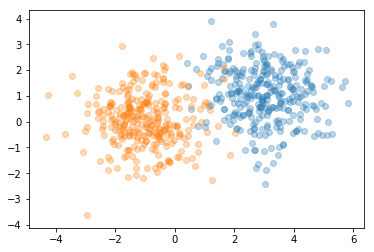

In [12]:
# Answer
n = 300
mu_c1 = np.array([3, 1])
mu_c2 = np.array([-1, 0])
X1 = np.random.randn(n, 2) + mu_c1
X2 = np.random.randn(n, 2) + mu_c2
plt.scatter(X1[:, 0], X1[:, 1], alpha=0.3)
plt.scatter(X2[:, 0], X2[:, 1], alpha=0.3)

Y1 = np.ones((n,))
Y2 = np.ones((n,)) * 2
X = np.vstack([X1, X2])
Y = np.hstack([Y1, Y2])

In [13]:
# Answer (fancy)
def generate_data(n, mu_c1, mu_c2, cov_c1=0, cov_c2=0, trn_frac=0.8):
    """For 2 classes only, 2D variables
    
    Parameters
    ----------
    n is number per class
    corr_mag is correlation btw 1st and 2nd dim
    slope is magnitude of 1st dim / 2nd dim
    mu_c1 and mu_c2 are means for each dimension of X1 and X2"""
    if cov_c1 is None:
        cov_c1 = np.array([[1, 0], [0, 1]])
    elif not isinstance(cov_c1, np.ndarray):
        cov_c1 = np.array([[1, cov_c1], [cov_c1, 1]])
    if cov_c2 is None:
        cov_c2 = np.array([[1, 0], [0, 1]])
    elif not isinstance(cov_c2, np.ndarray):
        cov_c2 = np.array([[1, cov_c2], [cov_c2, 1]])
    # First variable
    X1 = np.random.multivariate_normal(mu_c1, cov_c1, size=(n,))
    # Second variable
    X2 = np.random.multivariate_normal(mu_c2, cov_c2, size=(n,))    
    nn = np.int(n*trn_frac)
    Xt = np.vstack([X1[:nn], X2[:nn]])
    Xv = np.vstack([X1[nn:], X2[nn:]])
    Yt = np.hstack([np.ones(nn), np.ones(nn)*2])
    Yv = np.hstack([np.ones((n-nn,)), np.ones((n-nn,))*2])
    return Xt, Xv, Yt, Yv

def plot_classes(X1, X2, classifier=None, axis=(-5, 5, -5, 5), clfcolor='k', plot_data=True, ax=None):
    """For now: only linear classifier, only w/ 2D plots"""
    if ax is None:
        fig, ax = plt.subplots()
    if plot_data:
        ax.scatter(X1[:,0], X1[:,1], color='r', alpha=0.3)
        ax.plot(*mu_c1, color='r', marker='o', markeredgecolor='k')
        ax.scatter(X2[:,0], X2[:,1], color='b', alpha=0.3)
        ax.plot(*mu_c2, color='b', marker='o', markeredgecolor='k')
        ax.axis(axis)
    if classifier is not None:
        # useful: https://stackoverflow.com/questions/22294241/plotting-a-decision-boundary-separating-2-classes-using-matplotlibs-pyplot
        w = classifier.coef_[0]
        # Slope (m from y = mx + b)
        m = -w[0] / w[1]
        # Get intercept (b from y = mx + b)
        b = - (classifier.intercept_[0]) / w[1]
        # Sample some X values, and compute the corresponding Ys
        xx = np.linspace(-5, 5)
        yy = m * xx + b
        ax.plot(xx, yy, clfcolor+'-')

In [17]:
Yt.shape

(800,)

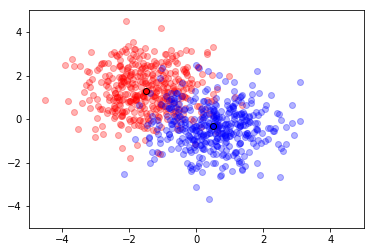

In [16]:
# Define 2D values for class 1
n = 500 # number of exemplars per class
#r = 0.6
mu_c1 = np.array([-1.5, 1.3])
mu_c2 = np.array([0.5, -0.3])
Xt, Xv, Yt, Yv = generate_data(n, mu_c1, mu_c2) #, cov_c1=r, cov_c2=r)

plot_classes(Xt[Yt==1], Xt[Yt==2])

# sklearn!

Now we will use the sklearn (scikit-learn) machine learning library to classify the points into each class! 

In [23]:
svmclf = svm.LinearSVC()

In [25]:
_ = svmclf.fit(Xt, Yt)

In [27]:
# Get SVM classifier base object
svmclf = svm.LinearSVC()
# Fit SVM classifier to data
_ = svmclf.fit(Xt, Yt)
# Predict new values
Ypred_svm = svmclf.predict(Xv)

In [28]:
Ypred_svm

array([1., 1., 1., 2., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 2., 1., 1., 1.,
       1., 1., 1., 2., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 2., 2.,
       2., 2., 2., 1., 2., 2., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       1., 2., 2., 2., 2., 2., 2., 1., 2., 2., 1., 2., 2., 2., 2., 2., 2.,
       1., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       1., 2., 2., 2., 1., 1., 1., 1., 2., 2., 2., 2., 2.])

In [29]:
ldaclf = da.LinearDiscriminantAnalysis()
# Fit LDA classifier to data
_ = ldaclf.fit(Xt, Yt)
# Predict new responses w/ LDA classifier
Ypred_lda = ldaclf.predict(Xv)

> How should we test accuracy?

In [37]:
# Answer
svm_acc = (Yv==Ypred_svm).mean()
lda_acc = (Yv==Ypred_lda).mean()
print(svm_acc, lda_acc)

0.885 0.88


In [39]:
svmclf.coef_, svmclf.intercept_

(array([[ 0.63467594, -0.48300304]]), array([0.52936591]))

# Show decision boundary 
### But first, a little basic algebra review...

Perhaps the most familiar form of a line is:

$y = mx + b$

...but a more general form for a line is the following: (this can take x, y, z,... arbitrarily many variables, each with a constant). 

$0 = Ax + By + C$

This form of a line is what is returned by the classification algorithms. To put this into the more familiar form (for a 2D line only), we can do the following:

$m = -A/B$ 

and

$b = -C/B$

In [40]:
# Ax + By + C form:
print(ldaclf.coef_) # [A, B]
print(ldaclf.intercept_) # [C]

[[ 2.14200483 -1.59789954]]
[1.80379805]


In [41]:
# Show slope & intercept of decision plane line for lda
print('Slope = %0.2f'%(- ldaclf.coef_[0][0]/ldaclf.coef_[0][1]))
print('Intercept = %0.2f'%(- ldaclf.intercept_[0]/ldaclf.coef_[0][1]))

Slope = 1.34
Intercept = 1.13


In [42]:
# Show slope & intercept of decision plane line for svm
print('Slope = %0.2f'%(- svmclf.coef_[0][0]/svmclf.coef_[0][1]))
print('Intercept = %0.2f'%(- svmclf.intercept_[0]/svmclf.coef_[0][1]))

Slope = 1.31
Intercept = 1.10


Plot decision boundary

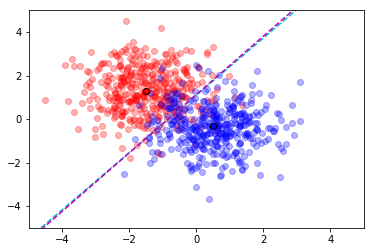

In [43]:
fig, ax = plt.subplots()
plot_classes(Xt[Yt==1], Xt[Yt==2], classifier=svmclf, clfcolor='c-', ax=ax)
plot_classes(Xt[Yt==1], Xt[Yt==2], classifier=ldaclf, clfcolor='m-', plot_data=False, ax=ax)

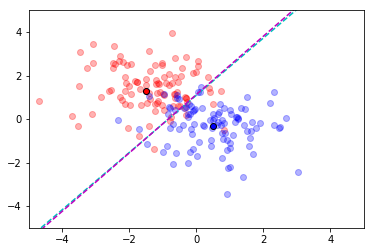

In [44]:
fig, ax = plt.subplots()
plot_classes(Xv[Yv==1], Xv[Yv==2], classifier=svmclf, clfcolor='c-', ax=ax)
plot_classes(Xv[Yv==1], Xv[Yv==2], classifier=ldaclf, clfcolor='m-', plot_data=False, ax=ax)

> How would you change the data to make the classifier more or less accurate? 

In [ ]:
# Answer



In [66]:
# Implement permutation! 1:200
acc = []
for rpt in range(1000):
    nshuf = len(Yt)
    ridx = np.random.permutation(np.arange(0, nshuf, 1))
    Yt_rand = Yt[ridx]
    #Yt_rand
    # Get SVM classifier base object
    svmclf_rnd = svm.LinearSVC()
    # Fit SVM classifier to data
    _ = svmclf_rnd.fit(Xt, Yt_rand)
    # Predict new values
    Ypred_svm_rand = svmclf_rnd.predict(Xv)
    acc.append(np.mean(Ypred_svm_rand==Yv))

(array([161.,  78.,  84.,  91.,  83.,  84., 105.,  83.,  84., 147.]),
 array([0.11 , 0.188, 0.266, 0.344, 0.422, 0.5  , 0.578, 0.656, 0.734,
        0.812, 0.89 ]),
 <a list of 10 Patch objects>)

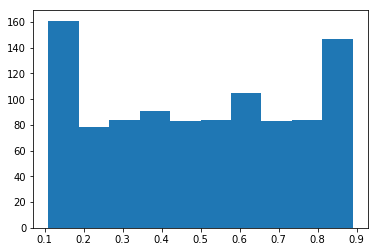

In [67]:
plt.hist(acc)

# MVPA on real fMRI data
Now, let's try this on something more interesting - actual fMRI data. We will analyze the data from a simple localizer experiment, and try to classify which type of stimulus is present for each TR of a withheld run. 

First, we have to define our `X` and `Y` variables. NOTE that here, X is voxels! Up to now, Y has been voxel activity, but in this analysis, the direction of fitting is backwards with respect to regression - we are using *voxel activity* to predict *stimulus class* rather than stimulus class (or stimulus features, or experimental condition) to predict voxel activity.

Thus, X will be voxels. Our first decision is WHICH voxels to include. We will NOT do a full-brain analysis, here - we will select a large region of interest from combining pre-existing ROIs, using pycortex. 

In [108]:
subject = 's03'
transform = 'category_localizer'
roi_masks = cx.get_roi_masks('s03', 'category_localizer', roi_list=['V1','V2','V3','V4',
                                                                    'LO','OFA','FFA','EBA',
                                                                   'PPA','RSC','OPA'])
all_masks = np.array(list(roi_masks.values()))
print(all_masks.shape)
mask = np.any(all_masks, axis=0)
print(mask.shape)
#cx.webgl.show(cx.Volume(mask, subject, transform))

/home/mark/.local/lib/python3.5/site-packages/cortex/svgoverlay.py:496: UserWarning: Shapely error - computing mean of points instead of geometric center
  warnings.warn("Shapely error - computing mean of points instead of geometric center")


Cutting 15 overlapping voxels (should be < ~50)
(11, 25, 104, 104)
(25, 104, 104)


In [109]:
mask.sum()

5844

> Show the mask using pycortex! Which voxels are selected? Did we do this right?

In [73]:
# Answer
V = cx.Volume(mask, subject, transform, vmin=0, vmax=1, cmap='gray')
h = cx.webgl.show(V, open_browser=False)

Started server on port 6136


Stopping server


Now, we will load 6 runs of localizer data, masking each run with the mask we have created to select only the voxels we care about

In [80]:
from scipy.stats import zscore

In [110]:
fdir = '/unrshare/LESCROARTSHARE/IntroToEncodingModels/'
fbase = os.path.join(fdir, 's03_catloc_run%02d.nii.gz')
data = []
for run in range(1, 7):
    nii = nibabel.load(fbase%run)
    # Transpose at load time to make the data [t, z, y, x]
    tmp = nii.get_data().T
    # Mask the data to select only the voxels we care about
    data.append(zscore(tmp[:, mask], axis=0))

In [82]:
data[0].shape

(120, 3467)

> How would you create training and testing X data from this list of arrays?


In [111]:
# Answer
Xt = np.vstack(data[:4])
Xv = np.vstack(data[4:])

In [84]:
Xt.shape

(480, 3467)

Now we need Y, the labels for classes. This will come from the design matrix of the localizer experiment (formerly known as X,for regression!). Each class will be the type of stimulus shown in each block of the experiment (faces, places, bodies, etc). 

In [87]:
with h5py.File(os.path.join(fdir, 'catloc_design.hdf')) as hf:
    print(list(hf.keys()))
    X = hf['X'].value
    xnames = hf['xnames'].value.tolist()
    # Ignore the 'decode' for now, it has to do with the format in which the strings were stored in this 
    # file, and it's just confusing...
    class_names = ['null'] + [x.decode() for x in xnames]
    events = hf['events'].value

['X', 'events', 'xnames']


> What are these variables? 

In [90]:
len(Xt) + len(Xv)

720

In [96]:
events

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5,

In [97]:
720/6

120.0

In [98]:
n_tr_per_run = 120
n_runs = 4
Yt = events[:n_tr_per_run*n_runs]
Yv = events[n_tr_per_run*n_runs:]

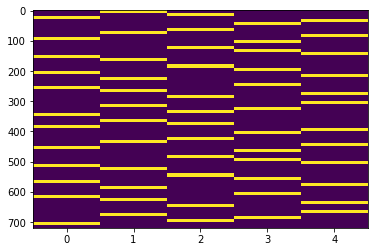

In [93]:
# Answer
plt.imshow(X, aspect='auto')
# (Display each variable, figure out what each is!)

Now we need Y variables. Which of these variables should be Y? 
> Define Y (The classes of the stimuli!) separately for training (Yt) and testing or validation (Yv)

In [ ]:
# Answer 


> Now, classify away! (Use the same sklearn classifiers we used above to try to classify the testing stimuli. Check how accurate your answers are!

In [112]:
# Answer
# Get SVM classifier base object
svmclf = svm.LinearSVC()
# Fit SVM classifier to data
_ = svmclf.fit(Xt, Yt)
# Predict new values
Ypred_svm = svmclf.predict(Xv)

In [113]:
np.mean(Ypred_svm==Yv)

0.8958333333333334

Sklearn gives you a nice way to make confusion matrices, too:

In [101]:
from sklearn import metrics

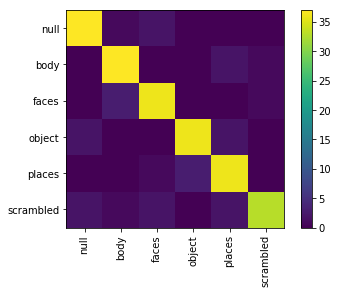

In [114]:
cmatrix = metrics.confusion_matrix(Yv, Ypred_svm)

# Show matrix
fig, ax = plt.subplots()
im = ax.imshow(cmatrix)
ax.set_xticks(np.arange(6))
ax.set_yticks(np.arange(6))
ax.set_xticklabels(class_names, rotation=90)
ax.set_yticklabels(class_names)
plt.colorbar(im)

## Now, let's show the classifier weights in pycortex!

> Where are the weights stored? 

(Remember that we are doing one-vs-all classifications, so there will be different weights to classify each class)

In [104]:
# Answer
svmclf.coef_.shape

(6, 3467)

In [105]:
np.unique(Yv)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

In [106]:
svmclf.coef_.max()

0.0490709558392029

In [115]:
# Answer
clf_wts = dict()
for i, cname in enumerate(class_names):
    clf_wts[cname] = cx.Volume(svmclf.coef_[i, :], subject, transform, 
                                        mask=mask, vmin=-0.05, vmax=0.05)

cx.webgl.show(clf_wts, open_browser=False)

Started server on port 49916


<WebApp(Thread-6, started 139639104403200)>

> How might you make your classification accuracy better? 

In [ ]:
# Answer